In [279]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics

In [278]:
#opinions_actual = [random.randint(0,2) for i in range(400)] + [0] * 800
#opinions_actual = [0,2] * 1500
opinions_actual = [0,0,0,1,2] * 600
#opinions_actual = [0,1,2] * 1000
#opinions_actual = [0] * 3000

In [266]:
def predict_opinions(actual, accuracy):
    ops_pred = []
    for op_act in actual:
        if random.random() < accuracy:
            op_pred = op_act
        else:
            op_pred = random.sample({0,1,2}^{op_act},1)[0]
        ops_pred.append(op_pred)
    return ops_pred

In [267]:
def calc_op_cons(opinions):
    op_cons = []
    ops_cum = np.array([0, 0, 0])
    for op in opinions:
        ops_cum[op] += 1
        op_cons.append((np.max(ops_cum[[0,2]]) + ops_cum[1]) / np.sum(ops_cum))
    return op_cons

In [268]:
opinion_cons_act = calc_op_cons(opinions_actual)

In [274]:
op_cons_pred_list = []
for i in range(400):
    op_cons_pred_list.append(calc_op_cons(predict_opinions(opinions_actual, 0.95)))

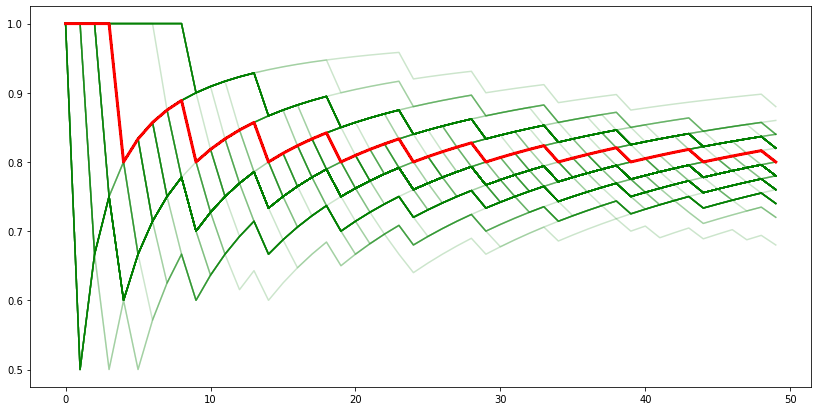

In [276]:
sub = 50
x = range(len(opinions_actual[:sub]))
fig, ax = plt.subplots(figsize=(14, 7))
for i in range(len(op_cons_pred_list)):
    ax.plot(x, op_cons_pred_list[i][:sub], alpha=0.2, color='g')
ax.plot(x, opinion_cons_act[:sub], color='r', linewidth=3)

In [260]:
def calculate_op_cons_internal(majority_ratio, minority_ratio, minority_is_neutral):
    if minority_is_neutral:
        return majority_ratio + minority_ratio
    else:
        return 1 - minority_ratio
def calculate_op_cons(classes):
    bins = np.bincount(classes, minlength=3)
    bins_sum = bins.sum(axis=-1)
    maj_ratio = bins.max(axis=-1) / bins_sum
    min_ratio = bins.min(axis=-1) / bins_sum
    return calculate_op_cons_internal(maj_ratio, min_ratio, np.argmin(bins) == 1)

In [261]:
CI = 0.95
SAMPLE_SIZES = [10, 30, 50, 100, 300, 500, 1500, 3000]
ERROR_MARGINS = [0.01, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20]
op_cons_preds = []
done = False
accuracy = 1.0
ACC_STEP = 0.01
min_accs = {}
has_improved = True
keep_searching = {}
for samples in SAMPLE_SIZES:
    keep_searching[samples] = {}
    for em in ERROR_MARGINS:
        min_accs[(em, samples)] = 1.0
        keep_searching[samples][em] = True

while has_improved and accuracy > 0:
    if accuracy < 0:
        accuracy = 0
    op_preds_list = []
    has_improved = False
    accuracy -= ACC_STEP
    print(f'calculating accuracy {accuracy}')
    for i in range(1000):
        op_preds = predict_opinions(opinions_actual, accuracy)
        op_preds_list.append(op_preds)
    for samples in SAMPLE_SIZES:
        if np.sum(list(keep_searching[samples].values())) == 0:
            continue
        op_cons_preds = []
        op_cons_act = calculate_op_cons(opinions_actual[:samples])
        for op_preds in op_preds_list:
            op_cons_pred = calculate_op_cons(op_preds[:samples])
            op_cons_preds.append(op_cons_pred)
        for em in ERROR_MARGINS:
            if not keep_searching[samples][em]:
                continue
            op_cons_preds = np.asarray(op_cons_preds)
            within_em = np.sum(np.abs(op_cons_preds-op_cons_act) < em/2.0)
            ratio_within_em = within_em / len(op_cons_preds)
            if ratio_within_em > CI:
                min_accs[(em, samples)] = accuracy
                has_improved = True
            else:
                keep_searching[samples][em] = False

calculating accuracy 0.99
calculating accuracy 0.98
calculating accuracy 0.97
calculating accuracy 0.96
calculating accuracy 0.95
calculating accuracy 0.94
calculating accuracy 0.9299999999999999
calculating accuracy 0.9199999999999999
calculating accuracy 0.9099999999999999
calculating accuracy 0.8999999999999999
calculating accuracy 0.8899999999999999
calculating accuracy 0.8799999999999999
calculating accuracy 0.8699999999999999
calculating accuracy 0.8599999999999999
calculating accuracy 0.8499999999999999
calculating accuracy 0.8399999999999999
calculating accuracy 0.8299999999999998
calculating accuracy 0.8199999999999998
calculating accuracy 0.8099999999999998


In [262]:
def to_latex_table(min_accs, path):
    with open(path, 'a+') as f:
        meta = f'CI: {CI} classes: {np.bincount(opinions_actual, minlength=3)}\n'
        f.write(meta)
        header = 'Error/Samples & ' + ' & '.join(map(str, SAMPLE_SIZES)) + ' \\\\\n'
        f.write(header)
        f.write("\\hline\\hline\n")
        for em in ERROR_MARGINS:
            accs = []
            for samples in SAMPLE_SIZES:
                accs.append(round(min_accs[(em, samples)], 2))
            line = f'{round(em*100)}\\%\t& ' + ' & '.join(map(lambda x: format(x, '.2f'), accs)) + ' \\\\\n'
            f.write(line)
        f.write("\n\n")

In [263]:
to_latex_table(min_accs, '../results/min_accuracies.txt')

In [280]:
pred_ops = [0] * len(opinions_actual)
print(metrics.classification_report(opinions_actual, pred_ops))


              precision    recall  f1-score   support

           0       0.60      1.00      0.75      1800
           1       0.00      0.00      0.00       600
           2       0.00      0.00      0.00       600

    accuracy                           0.60      3000
   macro avg       0.20      0.33      0.25      3000
weighted avg       0.36      0.60      0.45      3000



/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier